In [3]:
%matplotlib inline

In [4]:
import mne
import pathlib
import numpy as np
from matplotlib import pyplot as plt, ticker

plt.style.use(["minimal.mplstyle", "fast"])
mne.viz.set_browser_backend("matplotlib")

Using matplotlib as 2D backend.


In [5]:
RAW_DATA_PATH = pathlib.Path("../data/EEG")

SESSION = "group13b_own"

In [12]:
raw = mne.io.read_raw_brainvision(
    vhdr_fname = RAW_DATA_PATH.joinpath(SESSION + ".vhdr"),
    eog = ("HEOG", "VEOG"),
    misc = ("41",),
    preload = True,
    verbose = False
).rename_channels({
    "41": "STIM",
})
channel_types = {channel: type for channel, type in zip(raw.ch_names, raw.get_channel_types())}
order = dict(
    eeg = 0,
    eog = 1,
    misc = 2,
)
channel_names_by_type = sorted(channel_types.keys(), key = lambda name: order[channel_types[name]])
raw.reorder_channels(channel_names_by_type)

raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 30 EEG, 2 EOG, 1 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2024-02-29 14:40:42 UTC
 nchan: 33
 projs: []
 sfreq: 1000.0 Hz
>

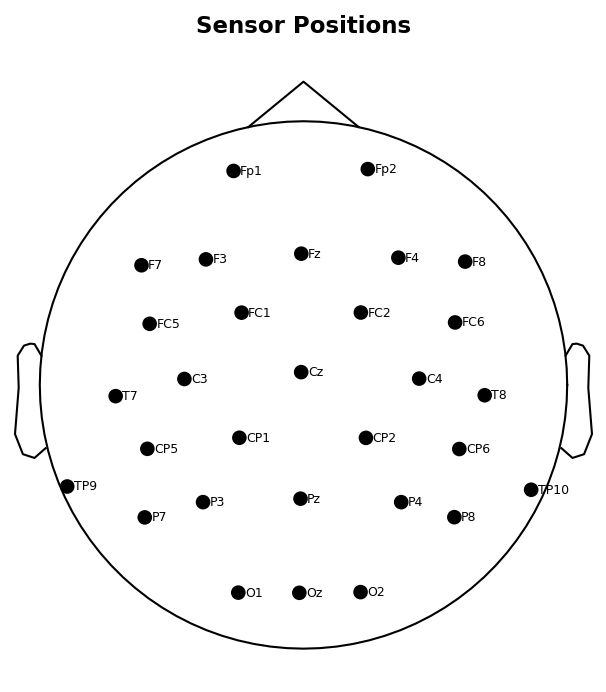

In [18]:
raw.set_montage(
    mne.channels.make_standard_montage("standard_1020"), 
    verbose=False
)
ax = raw.plot_sensors(
    show_names = True,
    sphere=(0, 0.02, 0, 0.1),
    show = False
).axes[0];
ax.set_title("Sensor Positions")
plt.sca(ax)
plt.show()

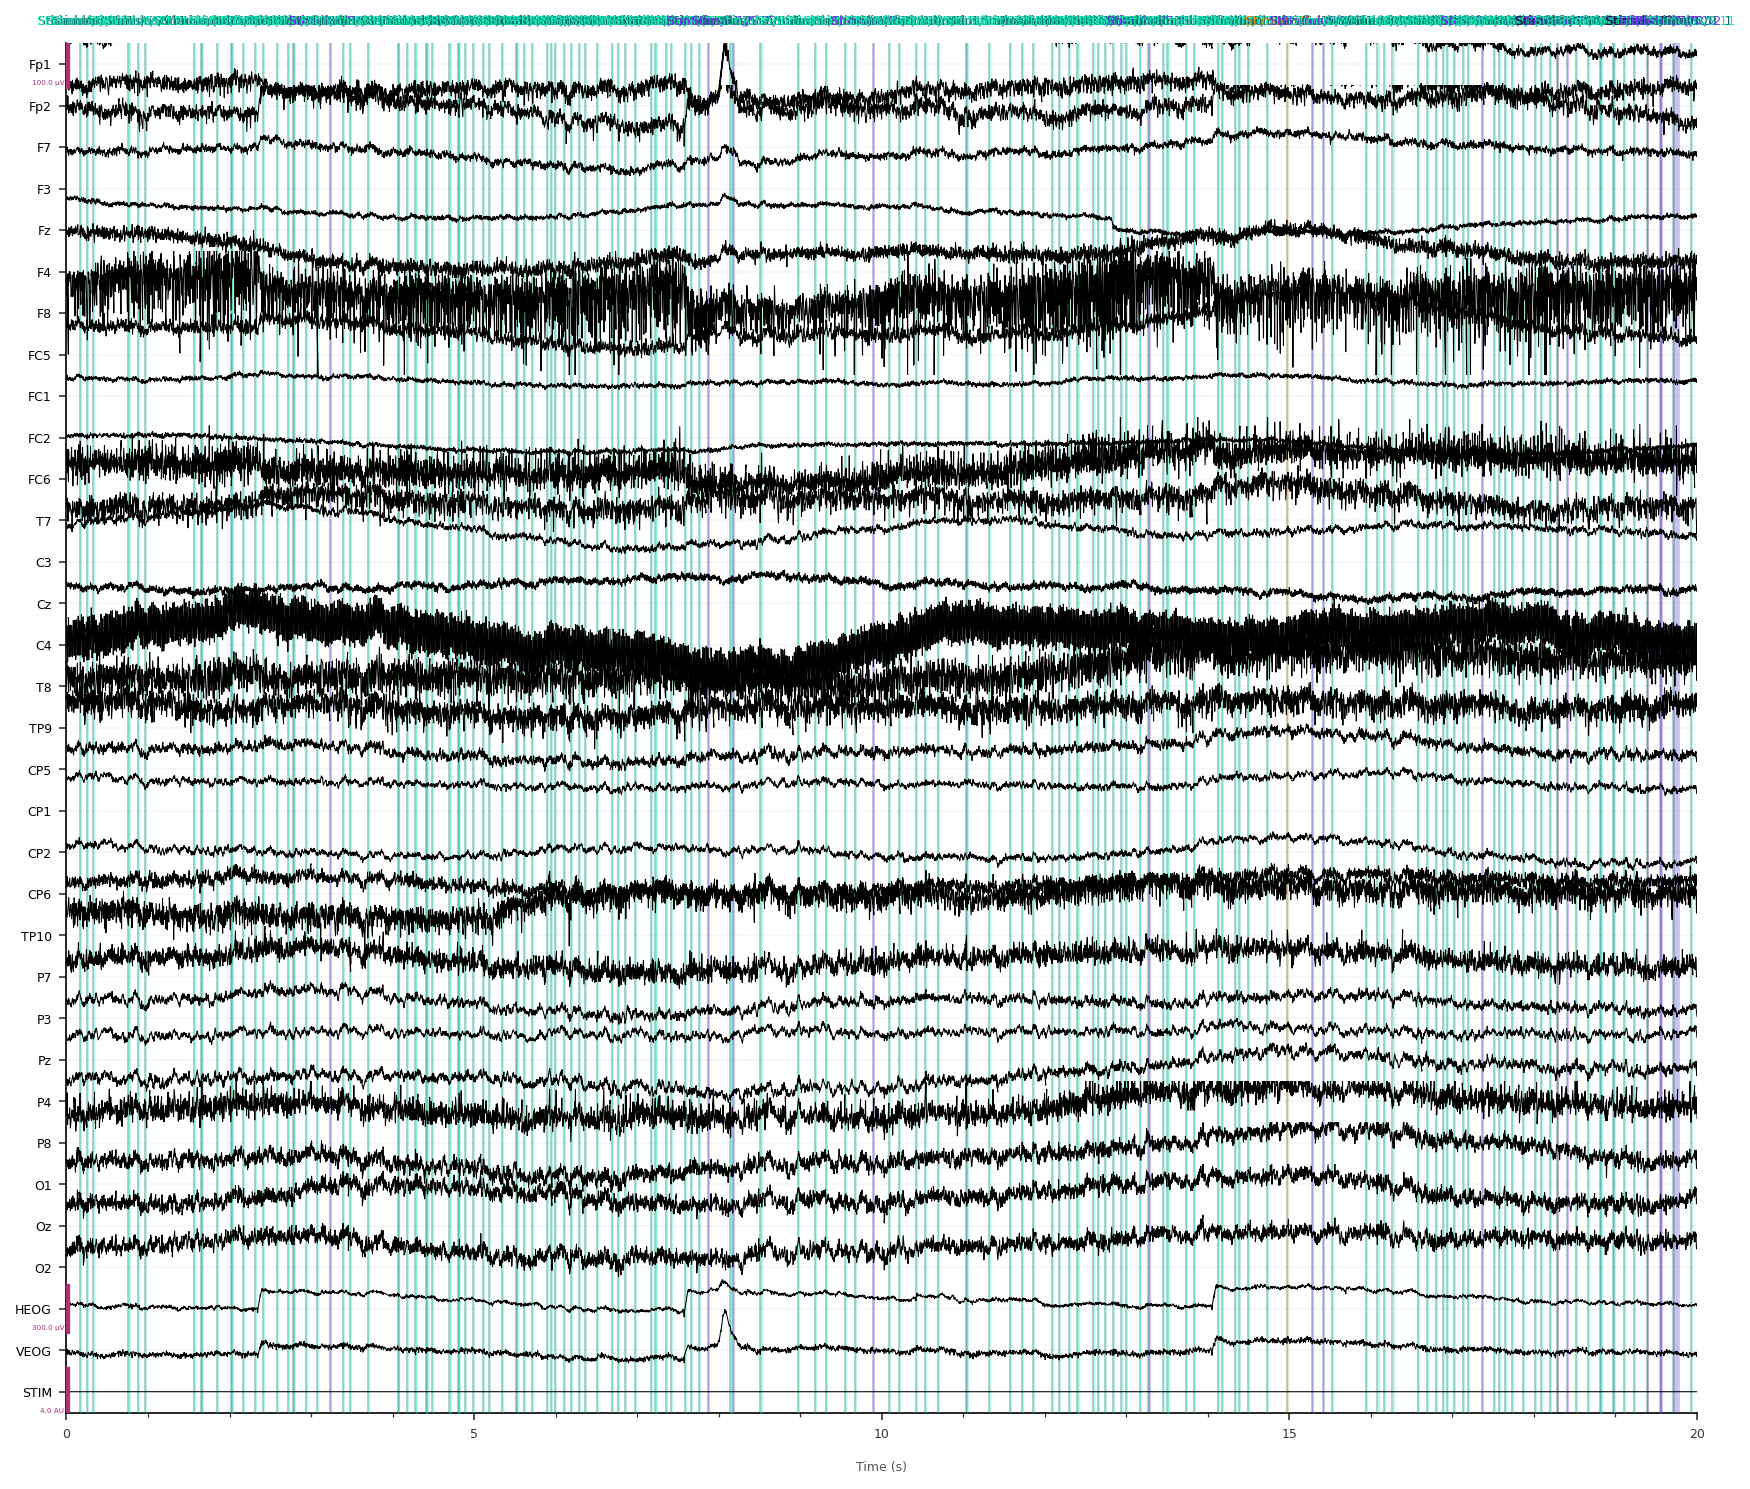

In [8]:
PLOT_SETTINGS = dict(
    n_channels=len(raw.ch_names),
    scalings=dict(
        eeg = 5e-5,
        misc = 2
    ),
    show = False,
)

preview_segmentation = dict(
    begin = 110,
    end = 130
)

raw_preview_segment = raw.copy().crop(
    tmin = preview_segmentation["begin"],
    tmax = preview_segmentation["end"],
)
fig = raw_preview_segment.plot(
    start = 0,
    duration = preview_segmentation["end"] - preview_segmentation["begin"],
    title = f"""Raw preview ({preview_segmentation["begin"]}s to {preview_segmentation["end"]}s)""",
    show_scrollbars = False,
    remove_dc = False,
    **PLOT_SETTINGS
)
fig.axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
fig.axes[0].xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_size_inches(12, 10)
plt.tight_layout()

In [9]:
raw.info.keys()

dict_keys(['acq_pars', 'acq_stim', 'ctf_head_t', 'description', 'dev_ctf_t', 'dig', 'experimenter', 'utc_offset', 'device_info', 'file_id', 'highpass', 'hpi_subsystem', 'kit_system_id', 'helium_info', 'line_freq', 'lowpass', 'meas_date', 'meas_id', 'proj_id', 'proj_name', 'subject_info', 'xplotter_layout', 'gantry_angle', 'bads', 'chs', 'comps', 'events', 'hpi_meas', 'hpi_results', 'projs', 'proc_history', 'custom_ref_applied', 'sfreq', 'dev_head_t', 'ch_names', 'nchan'])

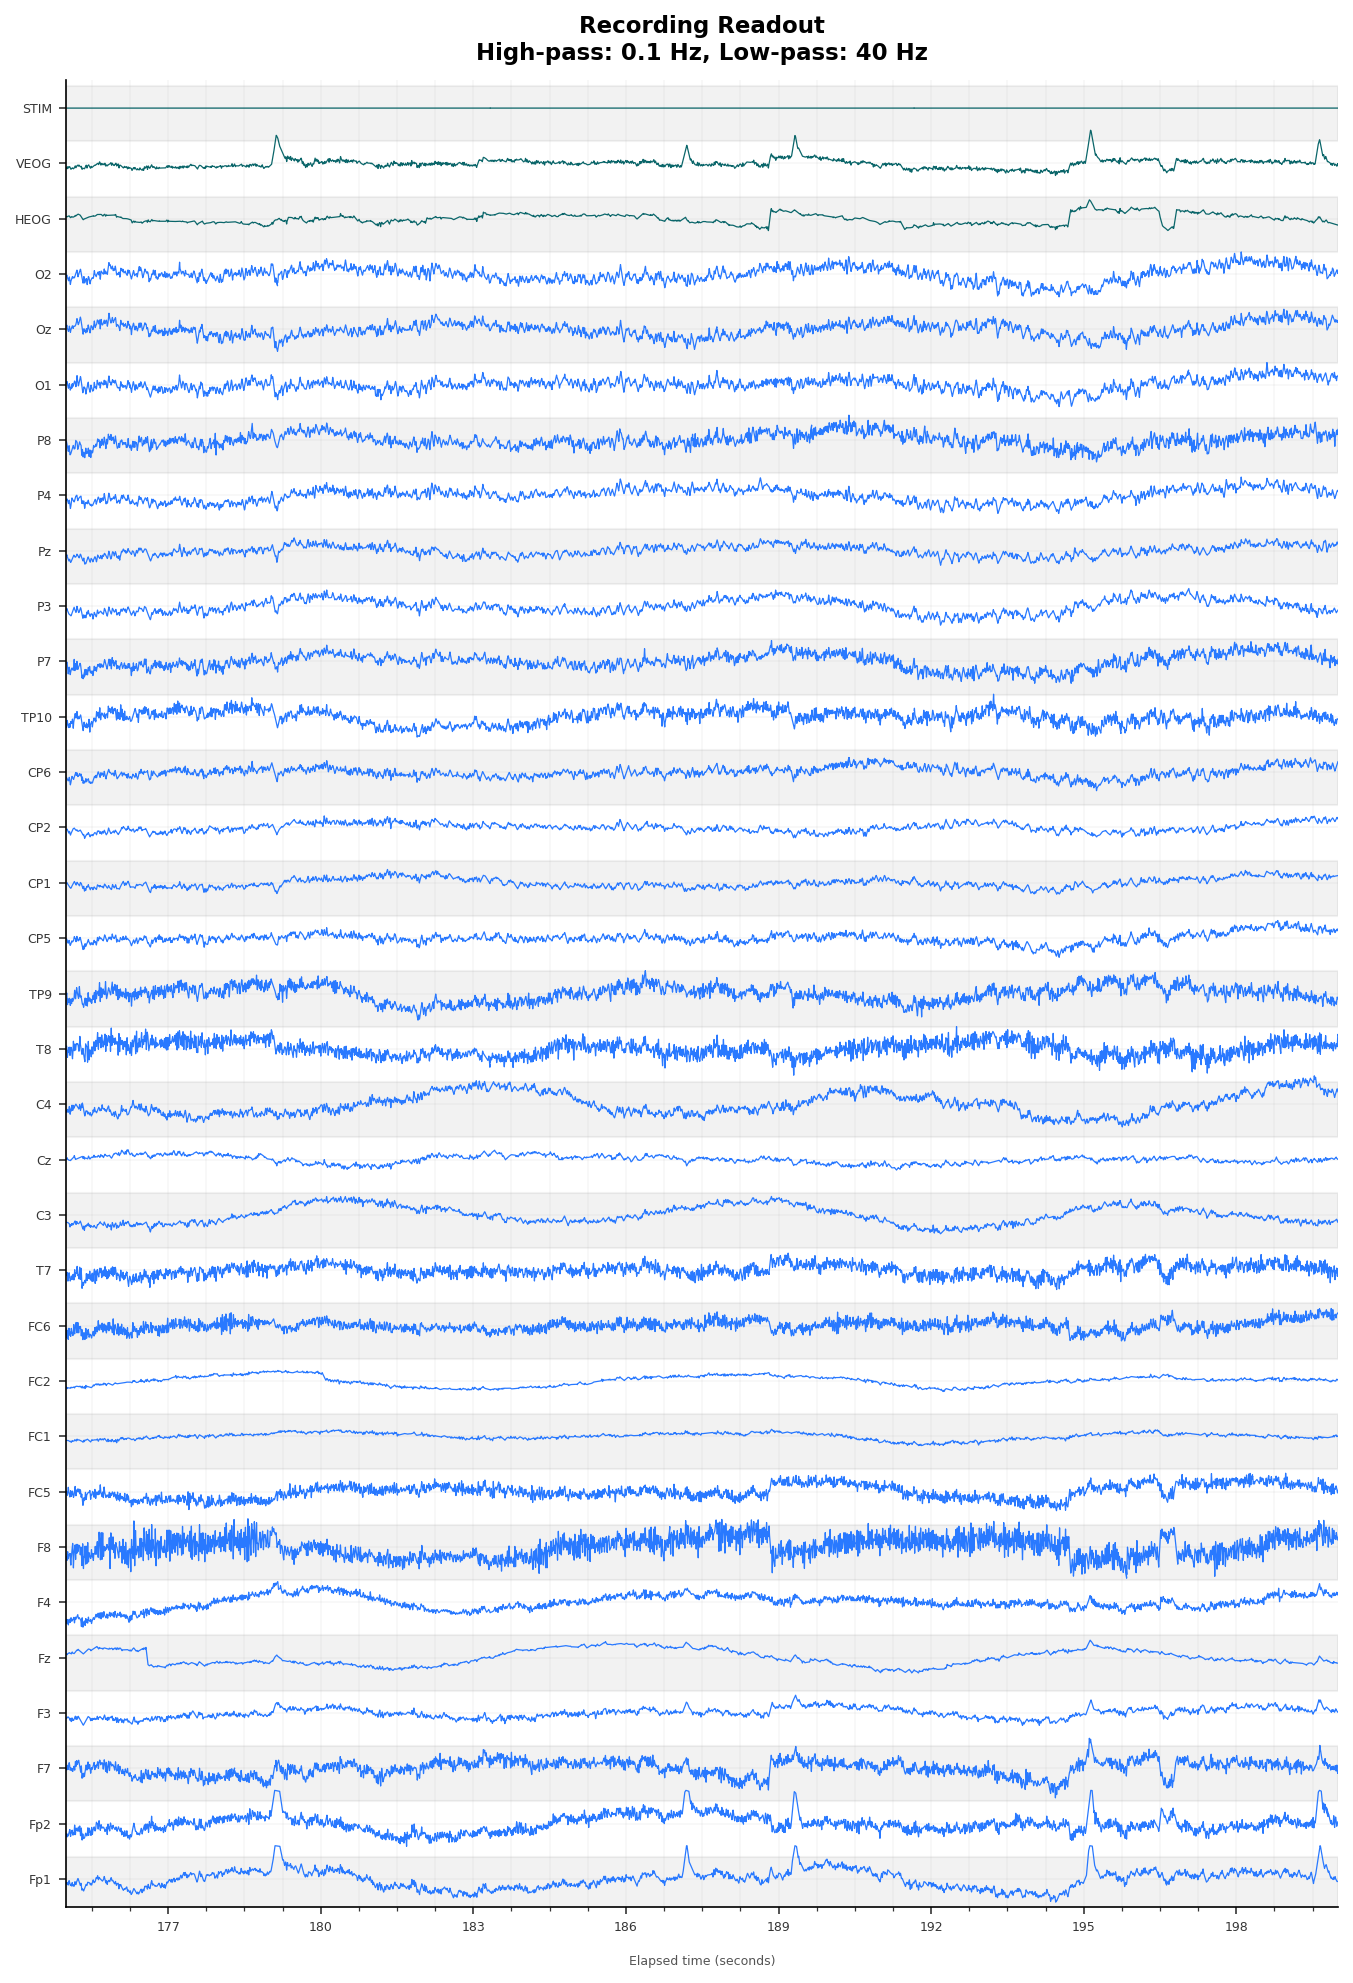

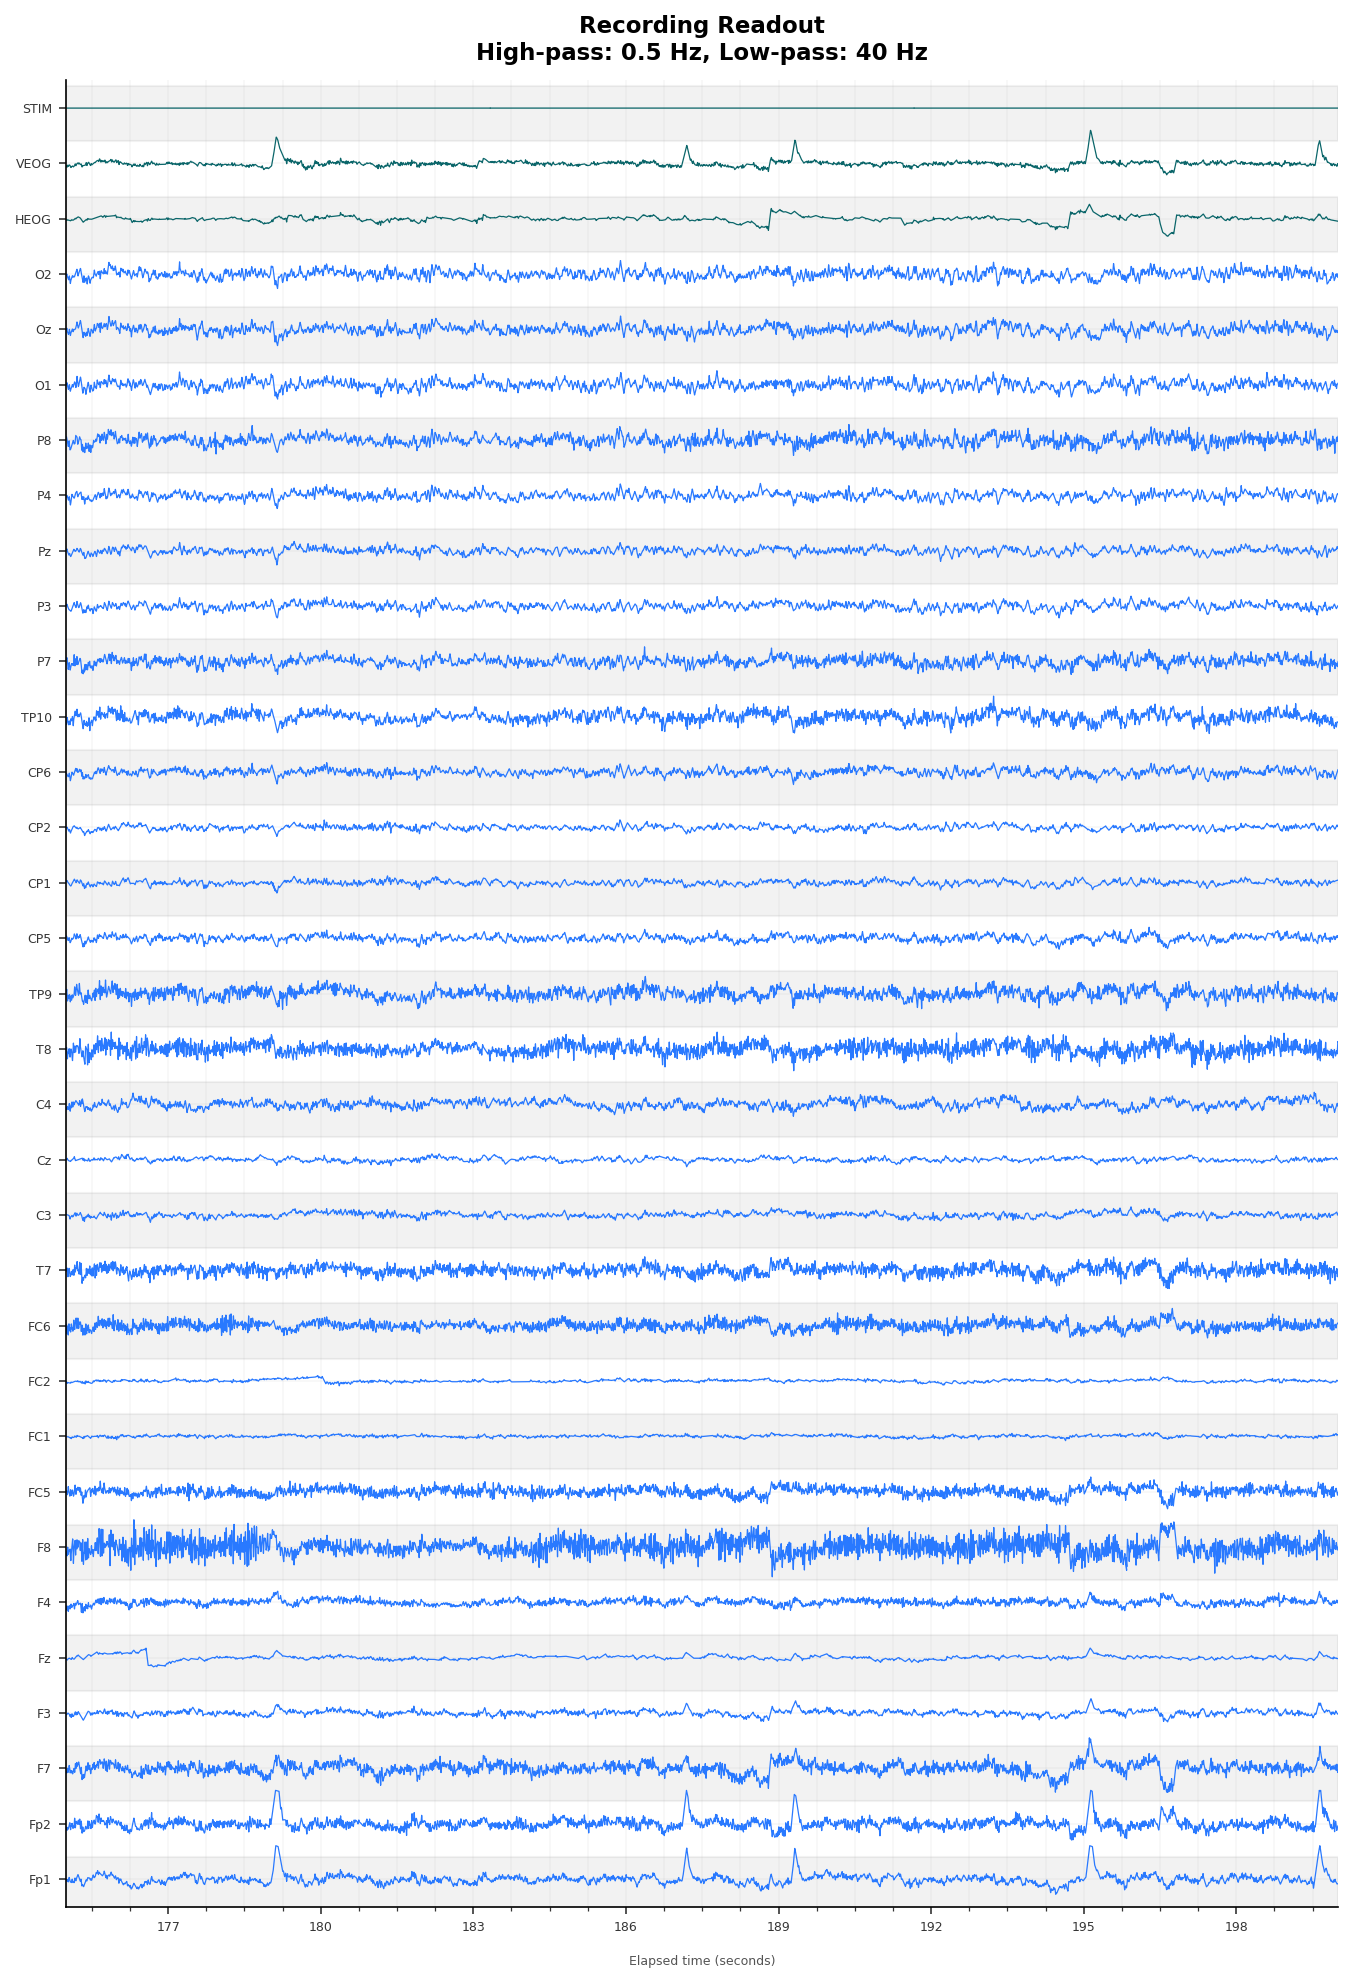

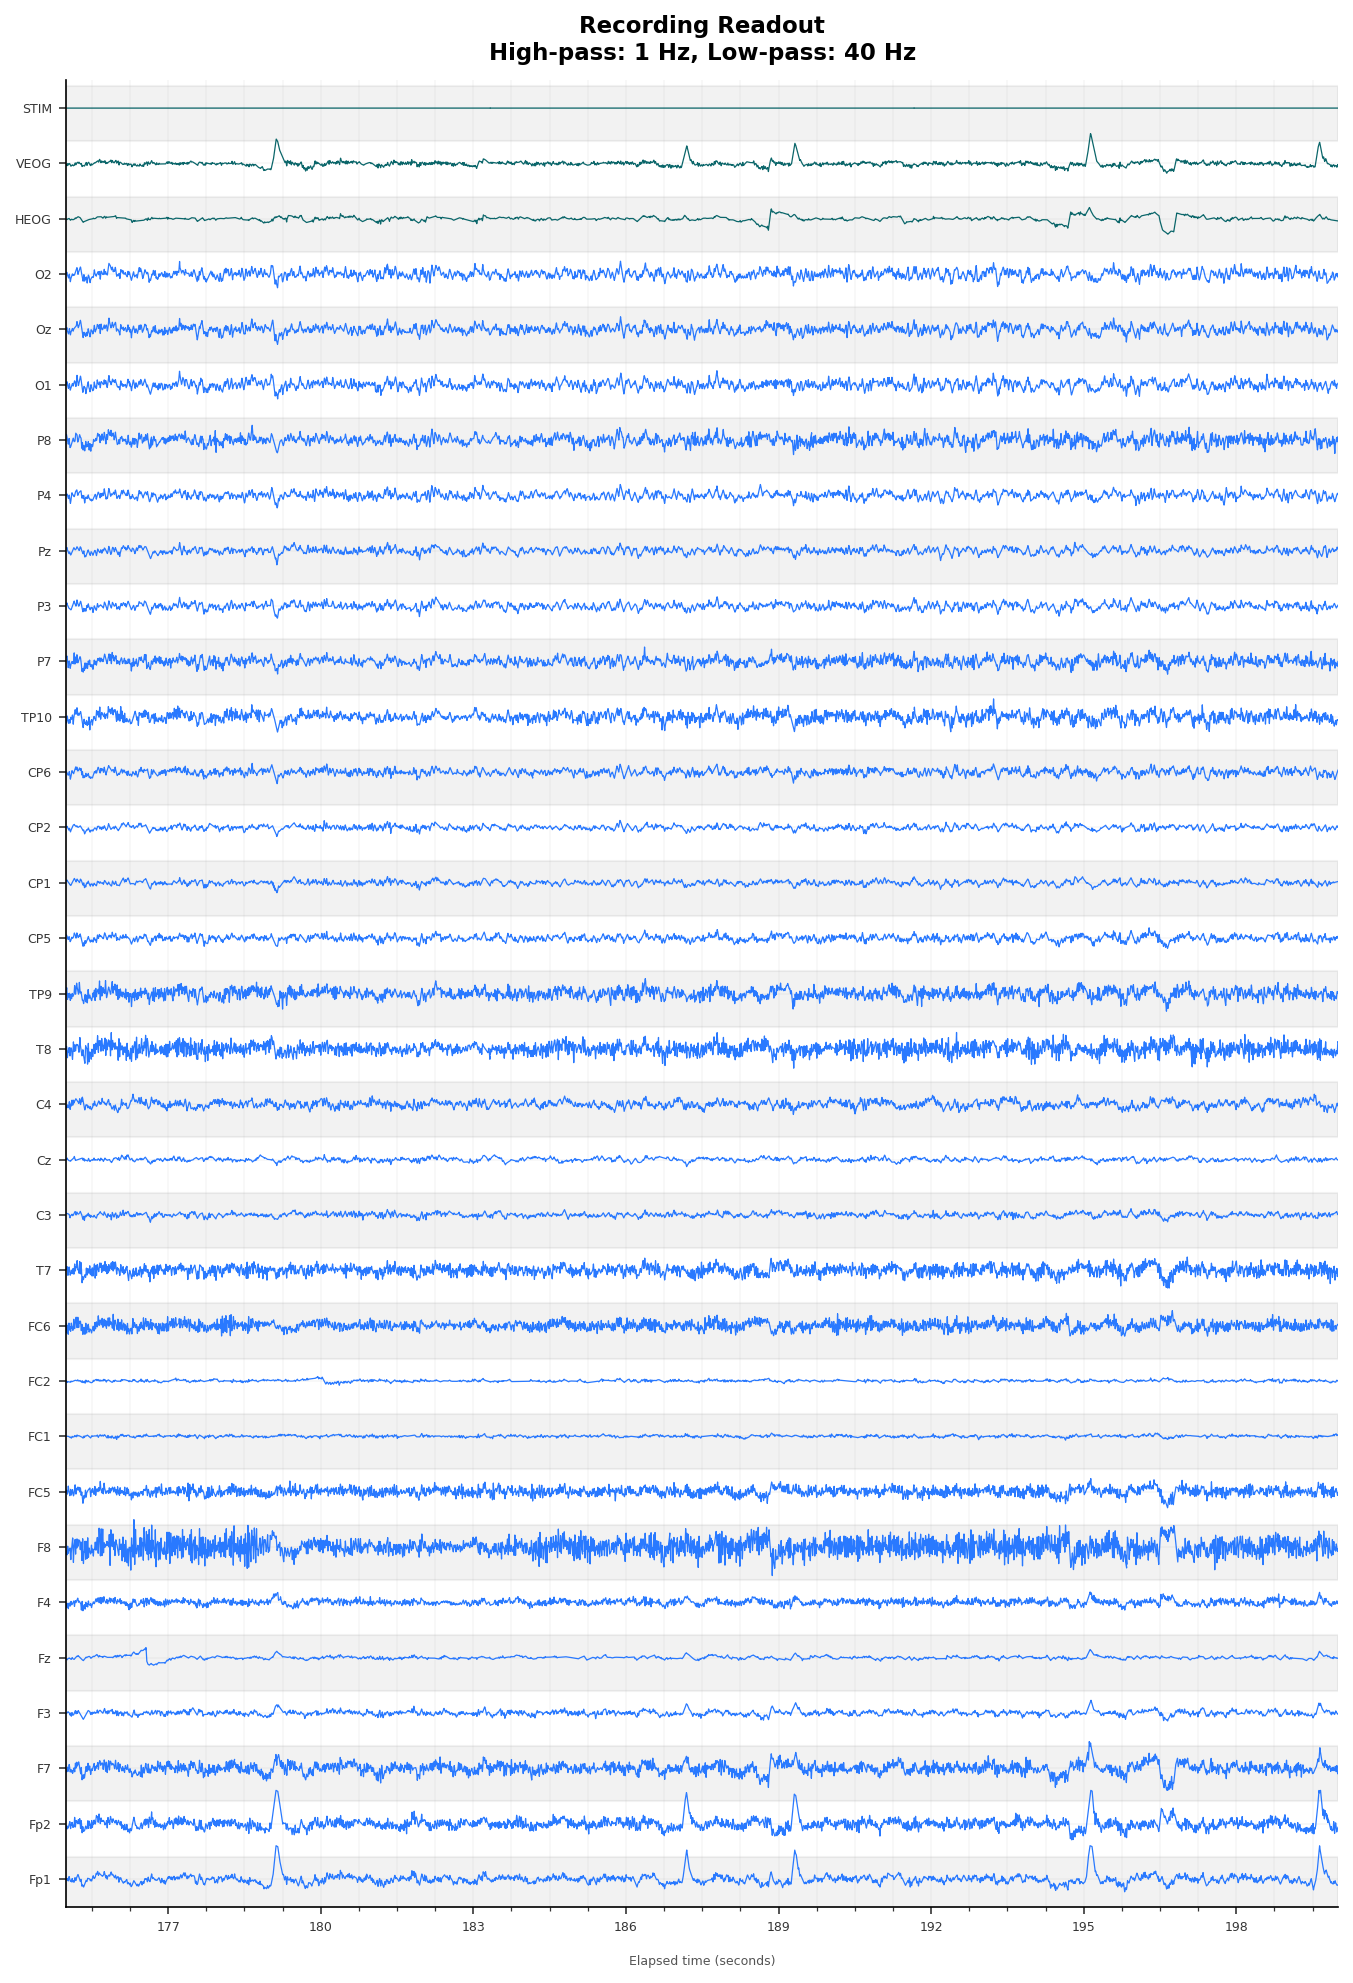

In [45]:
def show_readout(
    raw, 
    tmin = None, 
    tmax = None, 
    filter_cutoffs = dict(lower = None, upper = None), 
    scalings = dict(eeg = 150, eog = 450, misc = 4),
    overlap = 0.1,
):
    # sampling_frequency = raw.info["sfreq"]
    data = raw.copy().filter(
        picks = ["eeg", "eog"],
        l_freq = filter_cutoffs.get("lower", None), 
        h_freq = filter_cutoffs.get("upper", None),
        verbose = "error"
    )
    dataset = data.to_data_frame()

    tmin = tmin if tmin else 0
    tmax = tmax if tmin else dataset["time"].max()

    dataset = dataset[(dataset["time"] > tmin) & (dataset["time"] < tmax)]

    fig, ax = plt.subplots(figsize = (9, 0.4 * len(raw.ch_names)))

    max_span = 0.5 + overlap
    ax.set_yticks(range(raw.info["nchan"]), raw.ch_names)
    ax.grid(True, axis = "x", which = "both")
    for y0, y1 in zip(range(raw.info["nchan"] + 1)[::2], range(raw.info["nchan"] + 1)[1::2]):
        plt.axhspan(
            y0 - max_span, 
            y1 - max_span, 
            color="black", 
            alpha=0.05, 
            zorder=0
        )

    for channel_index, (channel, signal) in enumerate(dataset.set_index("time").items()):
        channel_type = channel_types[channel]
        scaled_signal = (signal - signal.mean()) / scalings[channel_type]
        bounded_signal = np.clip(scaled_signal, -max_span, max_span)
        ax.plot(
            channel_index + bounded_signal,
            linewidth = 0.6,
            color = "C6" if channel_type == "eeg" else "C0",
        )
    ax.set_xlim(tmin, tmax)
    ax.set_ylim(-0.5, raw.info["nchan"] - 0.5)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.set_xlabel("Elapsed time (seconds)")
    filter_info = [f"""High-pass: {filter_cutoffs["lower"]} Hz""" if filter_cutoffs["lower"] else "", f"""Low-pass: {filter_cutoffs["upper"]} Hz""" if filter_cutoffs["upper"] else ""]
    ax.set_title("Recording Readout" + (f"""\n{", ".join([info for info in filter_info if info])}""" if filter_info else "No filter"))

    plt.tight_layout()

# show_readout(raw)
tmin, tmax = 150, 160
tmin, tmax = 175, 200
# show_readout(raw, tmin = tmin, tmax = tmax)
show_readout(raw, tmin = tmin, tmax = tmax, filter_cutoffs=dict(lower = 0.1, upper = 40))
show_readout(raw, tmin = tmin, tmax = tmax, filter_cutoffs=dict(lower = 0.5, upper = 40))
show_readout(raw, tmin = tmin, tmax = tmax, filter_cutoffs=dict(lower = 1, upper = 40))
# show_readout(raw, tmin = tmin, tmax = tmax)

In [11]:
# bad_channels = {
#     "group13_own": [
#         "F8",
#         "T7",
#         "T8",
#         "TP10",
#     ],
#     "group13b_own": [
#         "F8",
#         "T7",
#         "T8",
#         "TP10",
#     ],
# }[SESSION]
# raw_filtered.info["bads"] = bad_channels

# fig, axes = plt.subplots(
#     nrows = len(raw.ch_names), 
#     figsize = (6, 0.5 * len(raw.ch_names))
# )
# for ax, channel, signal in zip(axes, raw.ch_names, raw.get_data(picks=raw.ch_names)):
#     ax.plot(signal[::sample_rate])

# data = pd.melt(
#     raw.to_data_frame(), 
#     id_vars = ["time"], 
#     var_name = "channel", 
#     value_name = "signal"
# )
# ax.plot(data["time"], data["signal"])